
CVaR-RL Risk-Sensitive Reinforcement Learning
Training CVaR-RL model...
Epoch 0, Loss: 20.1261
Epoch 20, Loss: 4.9600
Epoch 40, Loss: 3.2793


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Epoch 60, Loss: 2.2641
Epoch 80, Loss: 1.7798

Risk-Adjusted Decision Examples (First 10):
   order_id  base_reward  risk_adjusted_value  original_decision  \
0         0     3.703911             3.599151               True   
1         1     0.960980             1.045254               True   
2         2     0.561041             0.660850              False   
3         3     0.892199             0.728220               True   
4         4     0.524598             0.844415              False   
5         5     0.268258             0.278944              False   
6         6     0.832668             0.124854              False   
7         7     0.832049             0.661090              False   
8         8     1.068693             0.546649               True   
9         9     2.330789             5.922691               True   

   cvar_decision  delay_risk  overload_risk  
0           True         0.0       0.000000  
1           True         0.0       0.000000  
2          False      

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


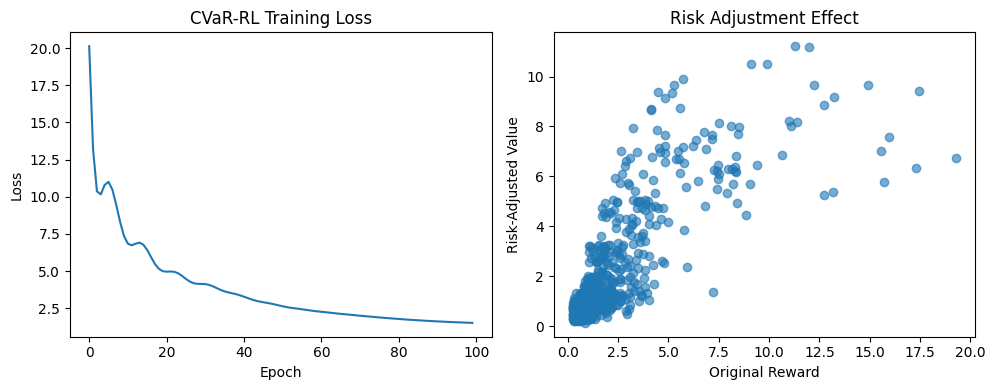

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

def cvar_rl_simulation():
    """
    Implement a simplified CVaR-RL algorithm for the FastShip scenario
    Input: None (uses generated fastship_data.csv)
    Output: Risk-adjusted rewards during training
    Function: Demonstrates the application of Conditional Value at Risk in reinforcement learning
    """
    import pandas as pd
    import torch
    import torch.nn as nn
    import torch.optim as optim

    # Load data
    try:
        df = pd.read_csv('fastship_data.csv')
    except:
        print("Dataset not found, generating...")
        df = generate_fastship_dataset()

    # Define CVaR network
    class CVaRNetwork(nn.Module):
        def __init__(self, input_dim, hidden_dim=64):
            super(CVaRNetwork, self).__init__()
            self.network = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)  # Output CVaR-adjusted value
            )

        def forward(self, x):
            return self.network(x)

    # Prepare data
    features = ['order_volume', 'order_priority', 'order_deadline',
                'vehicle_capacity', 'vehicle_speed', 'vehicle_cost_per_km',
                'distance', 'traffic_condition', 'weather_condition',
                'delay_risk', 'overload_risk']

    X = df[features].values
    y = df['base_reward'].values

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).unsqueeze(1)

    # Train CVaR network
    model = CVaRNetwork(input_dim=len(features))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # CVaR parameters
    alpha = 0.05  # Confidence level (5% worst-case scenarios)

    print("Training CVaR-RL model...")
    losses = []
    for epoch in range(100):  # Few epochs for demonstration
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_tensor)

        # Calculate CVaR loss
        residuals = y_tensor - predictions
        var_level = torch.quantile(residuals, alpha)
        mask = residuals <= var_level
        cvar_loss = torch.mean(residuals[mask]) if mask.any() else torch.tensor(0.0)

        # Combined loss
        total_loss = criterion(predictions, y_tensor) + 0.1 * cvar_loss

        total_loss.backward()
        optimizer.step()
        losses.append(total_loss.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item():.4f}")

    # Evaluate risk-adjusted decisions
    with torch.no_grad():
        risk_adjusted_values = model(X_tensor).squeeze().numpy()

    # Show first 10 decision examples
    print("\nRisk-Adjusted Decision Examples (First 10):")
    example_df = df.head(10).copy()
    example_df['risk_adjusted_value'] = risk_adjusted_values[:10]
    example_df['original_decision'] = example_df['base_reward'] > example_df['base_reward'].median()
    example_df['cvar_decision'] = example_df['risk_adjusted_value'] > example_df['risk_adjusted_value'].median()

    print(example_df[['order_id', 'base_reward', 'risk_adjusted_value',
                     'original_decision', 'cvar_decision', 'delay_risk', 'overload_risk']])

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('CVaR-RL Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.scatter(df['base_reward'], risk_adjusted_values, alpha=0.6)
    plt.xlabel('Original Reward')
    plt.ylabel('Risk-Adjusted Value')
    plt.title('Risk Adjustment Effect')
    plt.tight_layout()
    plt.show()

    return risk_adjusted_values

# Execute all demonstrations
if __name__ == "__main__":

    print("\n" + "=" * 50)
    print("CVaR-RL Risk-Sensitive Reinforcement Learning")
    print("=" * 50)
    cvar_rl_simulation()